In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '../src'))
from utils import load_corpus_data
from metrics import calculate_topk_accuracy
import faissEncoder as faiss_enc


/home/fernandogd/Documents/Investigacion/Transformers/Repositories/ClinLinker-KB/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CORPUS = "SympTEMIST"
DATA_PATH = "/scratch/data/"

models = []
results = []
F_TYPE = "FlatIP"
MAX_LENGTH = 256
TOP_N = 3
TOP_K_VALUES = [1,5,25,50,100,200]
mapped_semtag = {
    "estructura corporal": "body structure",
    "sustancia": "substance",
    "organismo": "organism",
    "anomalía morfológica": "morphologic abnormality",
    "hallazgo": "finding"
}

In [4]:
test_df, train_df, gaz_df = load_corpus_data(DATA_PATH, CORPUS)
gaz_df['semantic_tag'] = gaz_df['semantic_tag'].replace(mapped_semtag)
link_gaz_df = pd.concat([train_df[['code', 'term']], gaz_df[['code', 'term']]], ignore_index=True) 
no_code_count = test_df['code'].str.contains('NO_CODE').sum()
composite_count = test_df['code'].str.contains(r'\+').sum()
print(f"Number of NO_CODE: {no_code_count}")
print(f"Number of composite(+): {composite_count}")
test_df = test_df[~test_df['code'].str.contains('NO_CODE|\+', regex=True)]

Number of NO_CODE: 107
Number of composite(+): 0


In [5]:
code_sem_tag_dict = gaz_df.set_index('code')['semantic_tag'].to_dict()
test_df['sem_tag'] = test_df['code'].apply(lambda code: code_sem_tag_dict.get(code, "CODE_NOT_IN_DICT"))
test_sem_tag_counts = test_df['sem_tag'].value_counts().to_dict()
print(test_sem_tag_counts)

{'finding': 2068, 'disorder': 568, 'morphologic abnormality': 68, 'CODE_NOT_IN_DICT': 21, 'qualifier value': 7, 'navigational concept': 5, 'observable entity': 2, 'situation': 1, 'procedure': 1}


In [6]:
gaz_df.head()

,code,language,term,semantic_tag,mainterm
0,9991008,es,cólico abdominal,finding,1
1,9991008,es,cólico intestinal,finding,0
2,999000,es,"adenocarcinoma mixto, exocrino y de células de...",morphologic abnormality,1
3,999000,es,"adenocarcinoma mixto, de células insulares y c...",morphologic abnormality,0
4,9989000,es,anomalía congénita de dedo del pie,disorder,1


In [7]:
faiss_encoder = faiss_enc.FaissEncoder("ICB-UMA/ClinLinker-KB-GP", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fit_faiss()
candidates, codes, _ = faiss_encoder.get_candidates(test_df["term"].tolist(), k=200)
clinlinker_granparent_preds = test_df.copy()
clinlinker_granparent_preds["candidates"] = candidates
clinlinker_granparent_preds["codes"] = codes
models.append("ClinLinker-KB-GP")
results.append(clinlinker_granparent_preds)
del faiss_encoder

2025-04-26 14:26:07,125 - INFO - Vocabulary initialized successfully. (faissEncoder.py:76)
2025-04-26 14:27:22,105 - INFO - FAISS index fitted successfully. (faissEncoder.py:154)


In [8]:
faiss_encoder = faiss_enc.FaissEncoder("ICB-UMA/ClinLinker-KB-P", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fit_faiss()
candidates, codes, _ = faiss_encoder.get_candidates(test_df["term"].tolist(), k=200)
clinlinker_parent_preds = test_df.copy()
clinlinker_parent_preds["candidates"] = candidates
clinlinker_parent_preds["codes"] = codes
models.append("ClinLinker-KB-P")
results.append(clinlinker_parent_preds)
del faiss_encoder

2025-04-26 14:27:34,591 - INFO - Vocabulary initialized successfully. (faissEncoder.py:76)
2025-04-26 14:28:47,686 - INFO - FAISS index fitted successfully. (faissEncoder.py:154)


In [9]:
faiss_encoder = faiss_enc.FaissEncoder("ICB-UMA/ClinLinker", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fit_faiss()
candidates, codes, _ = faiss_encoder.get_candidates(test_df["term"].tolist(), k=200)
clinlinker_preds = test_df.copy()
clinlinker_preds["candidates"] = candidates
clinlinker_preds["codes"] = codes
models.append("ClinLinker")
results.append(clinlinker_preds)
del faiss_encoder

2025-04-26 14:29:00,265 - INFO - Vocabulary initialized successfully. (faissEncoder.py:76)
2025-04-26 14:30:13,333 - INFO - FAISS index fitted successfully. (faissEncoder.py:154)


In [10]:
faiss_encoder = faiss_enc.FaissEncoder("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR-large", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fit_faiss()
candidates, codes, _ = faiss_encoder.get_candidates(test_df["term"].tolist(), k=200)
baseline_preds = test_df.copy()
baseline_preds["candidates"] = candidates
baseline_preds["codes"] = codes
models.append("SapBERT-XLM-R-large")
results.append(baseline_preds)
del faiss_encoder

2025-04-26 14:30:41,890 - INFO - Vocabulary initialized successfully. (faissEncoder.py:76)
2025-04-26 14:35:36,317 - INFO - FAISS index fitted successfully. (faissEncoder.py:154)


2025-04-26 14:36:36,302 - INFO - Calculating Top-k accuracy... (metrics.py:39)
2025-04-26 14:36:36,302 - INFO - DataFrame size: 2068, Top-k values: [25] (metrics.py:40)
2025-04-26 14:36:36,412 - INFO - Top-25 accuracy: 0.9483 (metrics.py:67)
2025-04-26 14:36:36,412 - INFO - Top-k accuracy calculation complete. (metrics.py:69)
2025-04-26 14:36:36,414 - INFO - Calculating Top-k accuracy... (metrics.py:39)
2025-04-26 14:36:36,414 - INFO - DataFrame size: 568, Top-k values: [25] (metrics.py:40)
2025-04-26 14:36:36,448 - INFO - Top-25 accuracy: 0.8310 (metrics.py:67)
2025-04-26 14:36:36,448 - INFO - Top-k accuracy calculation complete. (metrics.py:69)
2025-04-26 14:36:36,449 - INFO - Calculating Top-k accuracy... (metrics.py:39)
2025-04-26 14:36:36,449 - INFO - DataFrame size: 68, Top-k values: [25] (metrics.py:40)
2025-04-26 14:36:36,453 - INFO - Top-25 accuracy: 0.8971 (metrics.py:67)
2025-04-26 14:36:36,454 - INFO - Top-k accuracy calculation complete. (metrics.py:69)
2025-04-26 14:36:36

/tmp/ipykernel_1098788/588225278.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


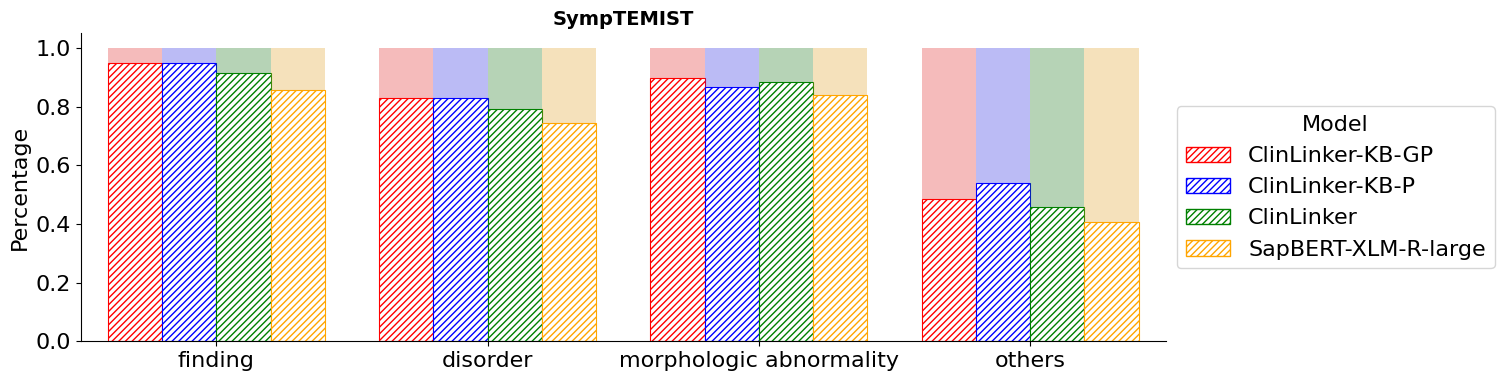

In [12]:
code_sem_tag_dict = gaz_df.set_index('code')['semantic_tag'].to_dict()
test_df['sem_tag'] = test_df['code'].apply(lambda code: code_sem_tag_dict.get(code, "CODE_NOT_IN_DICT"))
test_sem_tag_counts = test_df['sem_tag'].value_counts().to_dict()
top_tags = [k for k, v in sorted(test_sem_tag_counts.items(), key=lambda item: item[1], reverse=True)[:TOP_N]]

for df in results:
    df['tag'] = df['code'].map(code_sem_tag_dict).fillna('others')
    df['tag'] = df['tag'].apply(lambda x: x if x in top_tags else 'others')

results_dict = {}
topk_values = [25]
for i, model in enumerate(models):
    df = results[i]
    for tag in top_tags + ['others']:  
        filtered_df = df[df['tag'] == tag]
        accuracy_dict = calculate_topk_accuracy(filtered_df, topk_values)
        accuracy = accuracy_dict[25]
        if model not in results_dict:
            results_dict[model] = {}
        results_dict[model][tag] = accuracy

data = []
for model, tags in results_dict.items():
    for tag, accuracy in tags.items():
        data.append([model, tag, accuracy])

results_df = pd.DataFrame(data, columns=['Model', 'Tag', 'Accuracy'])

colors = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(14, 4))
ax = sns.barplot(x='Tag', y='Accuracy', hue='Model', data=results_df, palette=colors)

for bar in ax.patches:
    height = bar.get_height()
    ax.add_patch(plt.Rectangle((bar.get_x(), height), bar.get_width(), 1 - height, 
                                facecolor=bar.get_facecolor(), edgecolor='none', alpha=0.3))

bars = ax.patches[:len(results_df['Model'].unique()) * len(results_df['Tag'].unique())]
hatches = ['/////'] * len(bars)

model_color_mapping = {model: colors[i] for i, model in enumerate(models)}

for bar, hatch, model in zip(bars, hatches, results_df['Model']):
    bar.set_hatch(hatch)
    bar.set_edgecolor(model_color_mapping[model])
    bar.set_linewidth(0.8)
    bar.set_facecolor('white')

handles, labels = ax.get_legend_handles_labels()
for handle, model in zip(handles, models):
    handle.set_facecolor('white')
    handle.set_edgecolor(model_color_mapping[model])
    handle.set_hatch('/////')

ax.legend(handles, models, title='Model', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title_fontsize=16)

ax.set_ylim(0, 1.05)

ax.grid(False)

ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title(f'{CORPUS}', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, ha='center')
plt.savefig(f'../figures/{CORPUS}_bar_plot.pdf', bbox_inches='tight')                                                                                                                                                                               
plt.show()